## Imports

In [3]:
!pip install tensorflow
!pip install datasets
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import torch

tqdm.pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load dataset, define languages and labels for each

In [4]:
langs = ['java', 'python', 'pharo']
labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

java_train-00000-of-00001.parquet:   0%|          | 0.00/680k [00:00<?, ?B/s]

java_test-00000-of-00001.parquet:   0%|          | 0.00/174k [00:00<?, ?B/s]

python_train-00000-of-00001.parquet:   0%|          | 0.00/126k [00:00<?, ?B/s]

python_test-00000-of-00001.parquet:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

pharo_train-00000-of-00001.parquet:   0%|          | 0.00/113k [00:00<?, ?B/s]

pharo_test-00000-of-00001.parquet:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

Generating java_train split:   0%|          | 0/7614 [00:00<?, ? examples/s]

Generating java_test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Generating python_train split:   0%|          | 0/1884 [00:00<?, ? examples/s]

Generating python_test split:   0%|          | 0/406 [00:00<?, ? examples/s]

Generating pharo_train split:   0%|          | 0/1298 [00:00<?, ? examples/s]

Generating pharo_test split:   0%|          | 0/289 [00:00<?, ? examples/s]

DatasetDict({
    java_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 7614
    })
    java_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1725
    })
    python_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1884
    })
    python_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 406
    })
    pharo_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1298
    })
    pharo_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 289
    })
})

## Separate splits

In [5]:
java_train = ds['java_train']
python_train = ds['python_train']
pharo_train = ds['pharo_train']

java_test = ds['java_test']
python_test = ds['python_test']
pharo_test = ds['pharo_test']

## Find 98th percentile sentence length
This is to optimize our maximum sequence length

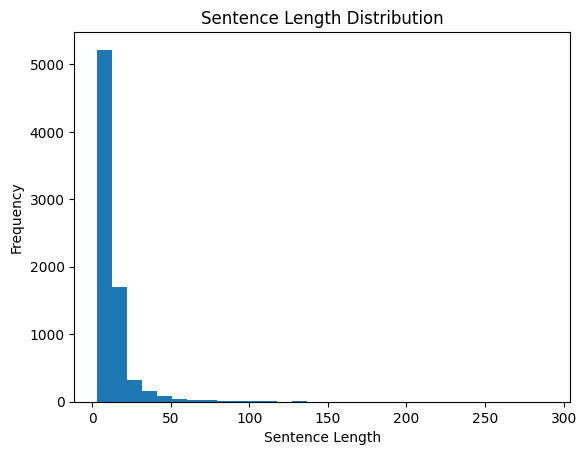

Max sequence length: 67


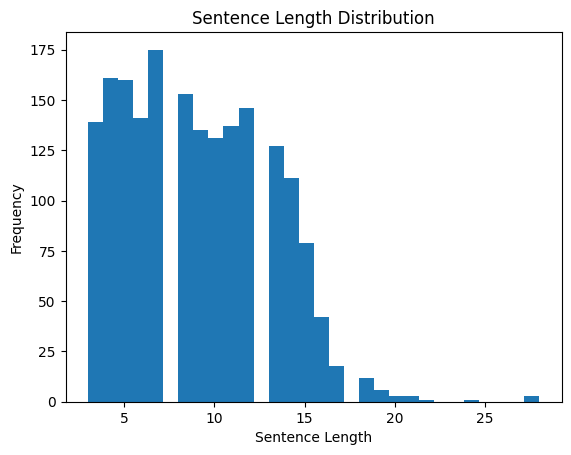

Max sequence length: 18


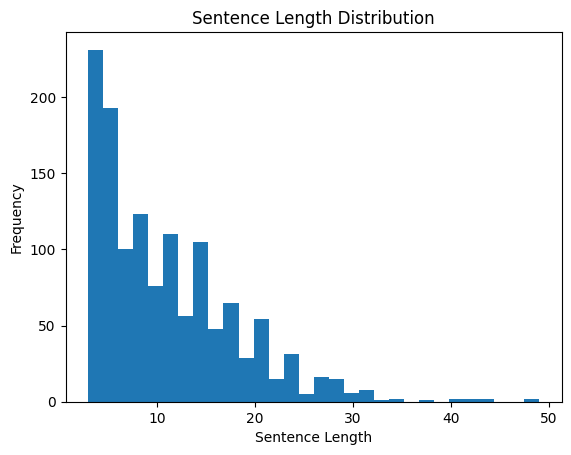

Max sequence length: 32


In [6]:
import matplotlib.pyplot as plt

for lan in langs:
  sentence_lengths = [len(sentence.split()) for sentence in ds[f'{lan}_train']['combo']]

  plt.hist(sentence_lengths, bins=30)
  plt.xlabel('Sentence Length')
  plt.ylabel('Frequency')
  plt.title('Sentence Length Distribution')
  plt.show()

  # Max sequence length
  max_length = int(np.percentile(sentence_lengths, 99))
  print(f"Max sequence length: {max_length}")

## Tokenizer function

In [20]:
tokenizer = Tokenizer(num_words=15000,)
def tokenize_data(data, tokenizer):
    return tokenizer.texts_to_sequences(data['combo'])

## Train models

In [22]:
max_sequence_length = 64

for lan in langs:
    # Load the dataset variables for specific language
    train_data = globals()[f'{lan}_train']
    test_data = globals()[f'{lan}_test']

    # Fit tokenizer
    tokenizer.fit_on_texts(train_data['combo'])

    # Tokenize and pad sequences for specific language
    train_token = tokenize_data(train_data, tokenizer)
    test_token = tokenize_data(test_data, tokenizer)

    train_padded = pad_sequences(train_token, maxlen=max_sequence_length)
    test_padded = pad_sequences(test_token, maxlen=max_sequence_length)

    # Labels arrays
    train_labels = np.array(train_data['labels'])
    test_labels = np.array(test_data['labels'])

    # Set output dimension for specific language
    output_dim = len(train_labels[0])

    # CNN model for each language
    model = Sequential([
        #
        Embedding(input_dim=15000, output_dim=128),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(256, 3, activation='relu'),
        MaxPooling1D(pool_size=4),
        # To help prevent overfitting
        Dropout(0.5),
        Flatten(),
        # sigmoid allows for binary classification
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(optimizer= Adam(), loss= 'binary_crossentropy', metrics=['accuracy'])

    # Change the number of epochs and batch size for java vs python and pharo
    epoch = 0
    batch = 0
    if lan == 'java':
      epoch = 9
      batch = 32

      # Fit and save model
      model.fit(train_padded, train_labels, epochs=epoch, batch_size=batch, validation_data=(test_padded, test_labels))
      model.save(f'/content/{lan}_cnn_model.keras')
    else:
      epoch = 8
      batch = 12

      # Fit and save model
      model.fit(train_padded, train_labels, epochs=epoch, batch_size=batch, validation_data=(test_padded, test_labels))
      model.save(f'/content/{lan}_cnn_model.keras')

Epoch 1/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4686 - loss: 0.3551 - val_accuracy: 0.5699 - val_loss: 0.2501
Epoch 2/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6442 - loss: 0.2272 - val_accuracy: 0.6481 - val_loss: 0.2332
Epoch 3/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6951 - loss: 0.1876 - val_accuracy: 0.6510 - val_loss: 0.2402
Epoch 4/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.1715 - val_accuracy: 0.5832 - val_loss: 0.2519
Epoch 5/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7381 - loss: 0.1550 - val_accuracy: 0.6464 - val_loss: 0.2803
Epoch 6/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7581 - loss: 0.1437 - val_accuracy: 0.6446 - val_loss: 0.2991
Epoch 7/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7715 - loss: 0.1339 - val_accuracy: 0.6261 - val_loss: 0.3330
Epoch 8/9
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7775 - loss: 0.1289 - val_accuracy: 0.5646 - 

## Function to count flops

In [9]:
def get_flops(path):
  # Create session and graph
  session = tf.compat.v1.Session()
  graph = tf.compat.v1.get_default_graph()

  with graph.as_default():
    with session.as_default():
      # Load model
      model = tf.keras.models.load_model(path)

      # Store runtime data
      run_meta = tf.compat.v1.RunMetadata()

      # Configure profiler
      opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

      # Run profiler
      flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

      return flops.total_float_ops

## Testing

In [29]:
total_flops = 0
total_time = 0
scores = []

for lan in langs:
    model = load_model(f"/content/{lan}_cnn_model.keras")

    # Test data setup
    test_data = globals()[f'{lan}_test']
    test_token = tokenize_data(test_data, tokenizer)
    test_padded = pad_sequences(test_token, maxlen=max_sequence_length)
    test_labels = np.array(test_data['labels'])


    start_time = time.time()

    for i in range(10):
      y_pred = model.predict(test_padded)

    # Reset flop count graph
    tf.compat.v1.reset_default_graph()

    # Count time and flops
    total_time += (time.time() - start_time)
    total_flops += get_flops(f"/content/{lan}_cnn_model.keras")

    y_true = test_labels
    y_pred = (y_pred > 0.5).astype(int)

    # Precision, Recall, F1
    for i in range(y_true.shape[1]):
        tp = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 1))
        tn = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 0))
        fp = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 1))
        fn = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 0))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        scores.append({'lan': lan, 'cat': labels[lan][i], 'precision': precision, 'recall': recall, 'f1': f1})

# Calc averages
print("Avg runtime in seconds:", total_time / 10)
print("Total GFLOPs:", total_flops / 10)

scores = pd.DataFrame(scores)
print(scores)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━

In [32]:
max_avg_runtime = 5
max_avg_flops = 5000

# s𝑢𝑏𝑚𝑖𝑠𝑠𝑖𝑜𝑛_𝑠𝑐𝑜𝑟𝑒(𝑚𝑜𝑑𝑒𝑙)=(𝑎𝑣𝑔. 𝐹1)×0.60+((𝑚𝑎𝑥_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒−𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑑_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒)/𝑚𝑎𝑥_𝑎𝑣𝑔_𝑟𝑢𝑛𝑡𝑖𝑚𝑒)×0.2+((𝑚𝑎𝑥_GFLOPs−𝑚𝑒𝑎𝑠𝑢𝑟𝑒𝑑_GFLOPs)/𝑚𝑎𝑥_GFLOPs)×0.2
def score(avg_f1, avg_runtime, avg_flops):
    return (0.6 * avg_f1 +
      0.2 * ((max_avg_runtime - avg_runtime) / max_avg_runtime) +
      0.2 * ((max_avg_flops - avg_flops) / max_avg_flops))


avg_f1 = scores['f1'].mean()
avg_runtime = total_time/10
avg_flops = total_flops/10

round(score(avg_f1, avg_runtime, avg_flops), 2)

-52.76